In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchdiffeq import odeint_adjoint as odeint
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms.v2 import GaussianNoise

In [23]:
def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)
rtol = 1e-3
atol = 1e-3

In [24]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=rtol, atol=atol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [25]:
downsampling_layers = [
nn.Conv2d(1, 64, 3, 1),
norm(64),
nn.ReLU(inplace=True),
nn.Conv2d(64, 64, 4, 2, 1),
norm(64),
nn.ReLU(inplace=True),
nn.Conv2d(64, 64, 4, 2, 1),
]
feature_layers = [ODEBlock(ODEfunc(64))]
fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]
model = nn.Sequential(
    *downsampling_layers,
    *feature_layers,
    *fc_layers
)

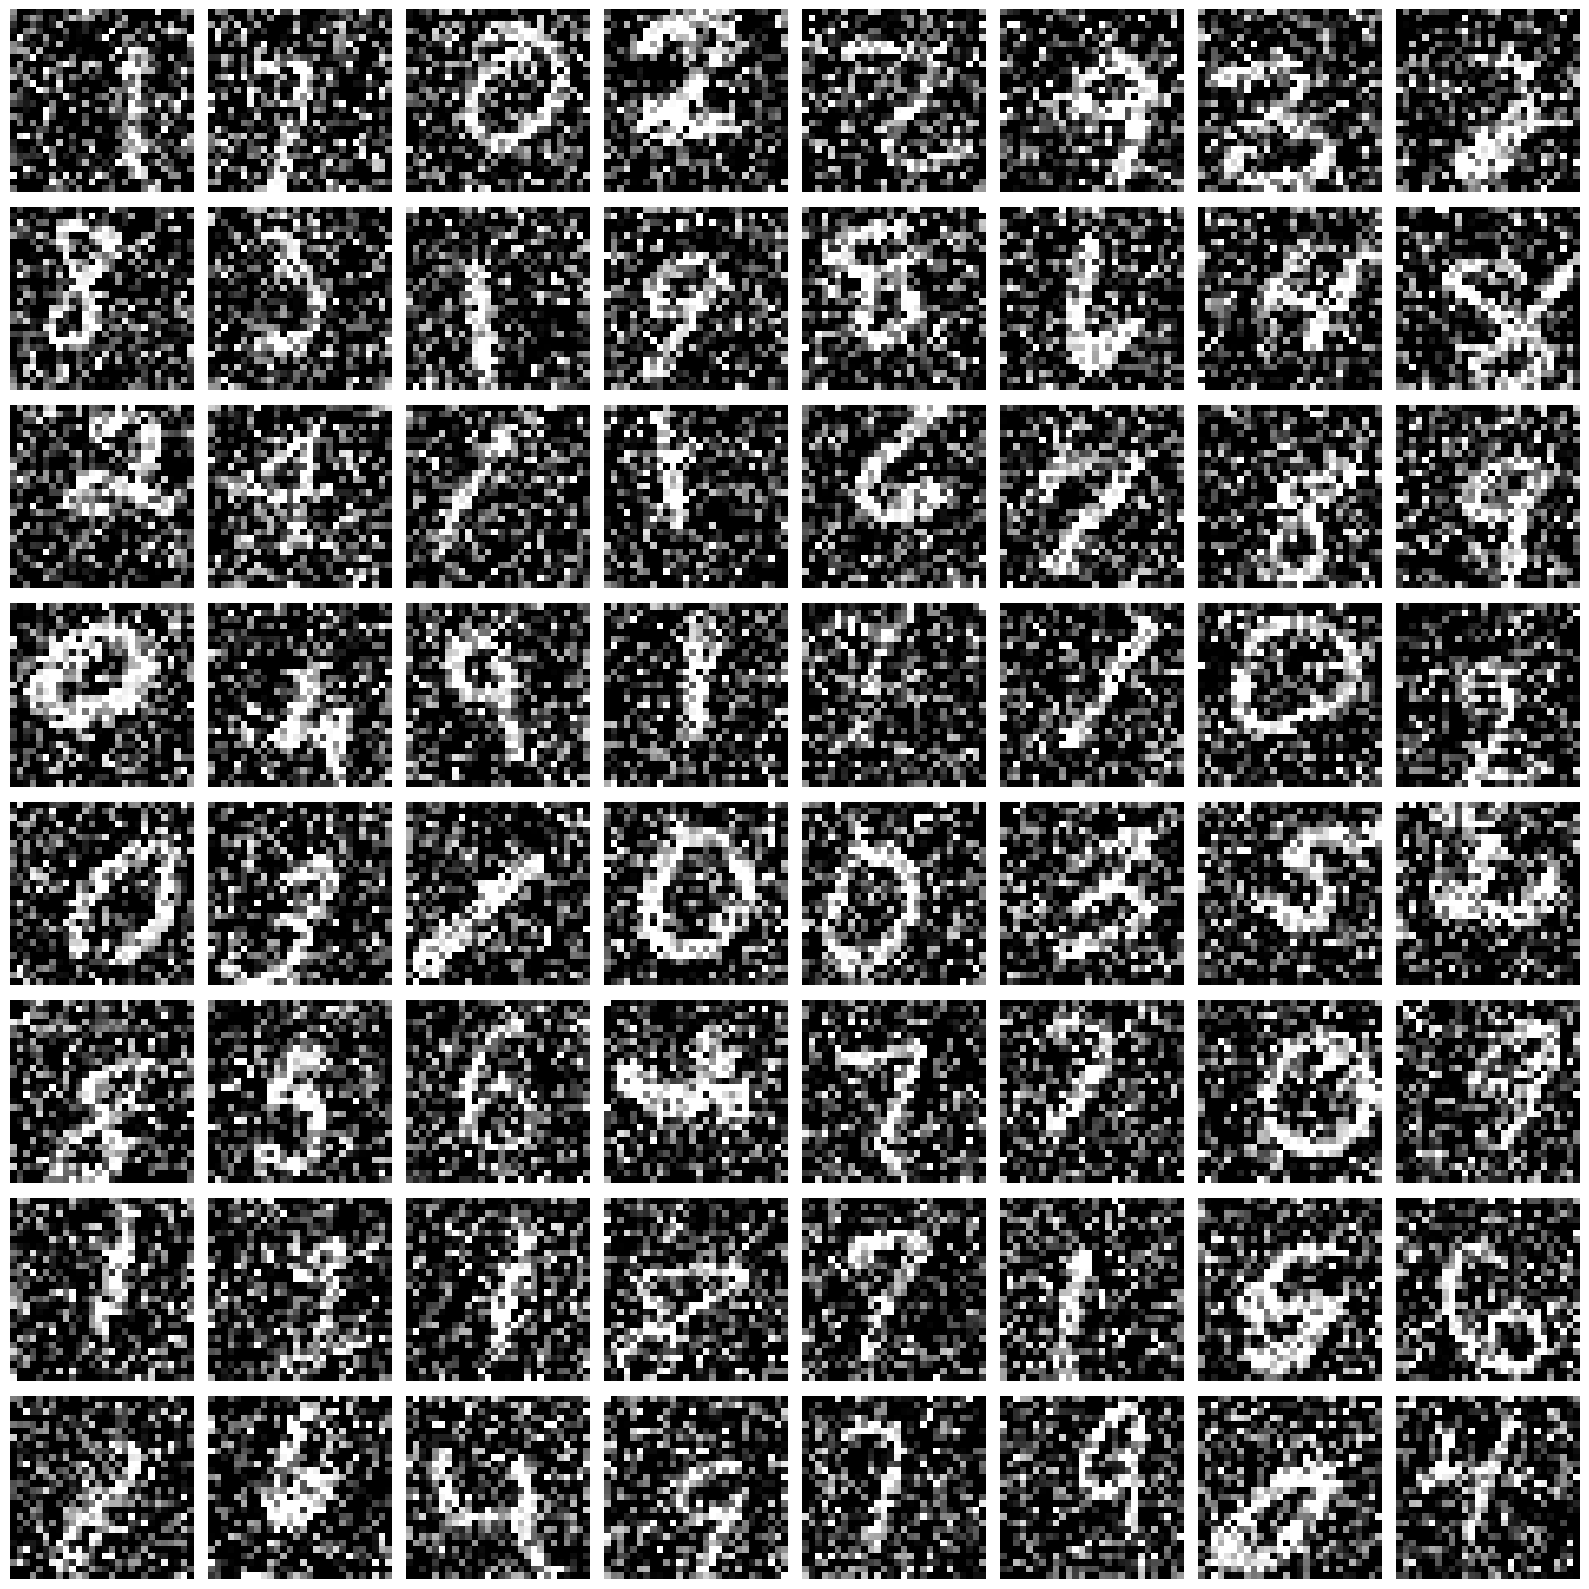

In [26]:
# Test on data with maximum noise
transform = transforms.Compose([
transforms.RandomCrop(28, padding=4),
transforms.ToTensor(),
GaussianNoise(mean=0.0, sigma=0.5)
])
mnist = datasets.MNIST(root='./.data/mnist', train=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)
def show_images(images, ncols=8):
    nrows = (len(images) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images(next(iter(dataloader))[0])

Testing euler solver 
 --- Processed 1024 images
 --- Accuracy of the model with euler solver trained at sigma 0.0, testing at sigma 0.0: 97.36% 

Testing euler solver 
 --- Processed 1024 images
 --- Accuracy of the model with euler solver trained at sigma 0.0, testing at sigma 0.1: 96.58% 

Testing euler solver 
 --- Processed 1024 images
 --- Accuracy of the model with euler solver trained at sigma 0.0, testing at sigma 0.25: 93.46% 

Testing euler solver 
 --- Processed 1024 images
 --- Accuracy of the model with euler solver trained at sigma 0.0, testing at sigma 0.5: 63.09% 

Testing dopri8 solver 
 --- Processed 1024 images
 --- Accuracy of the model with dopri8 solver trained at sigma 0.0, testing at sigma 0.0: 99.02% 

Testing dopri8 solver 
 --- Processed 1024 images
 --- Accuracy of the model with dopri8 solver trained at sigma 0.0, testing at sigma 0.1: 99.02% 

Testing dopri8 solver 
 --- Processed 1024 images
 --- Accuracy of the model with dopri8 solver trained at sigma 

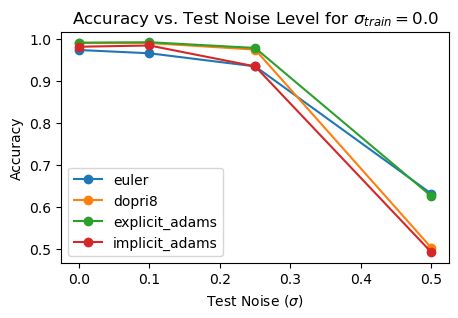

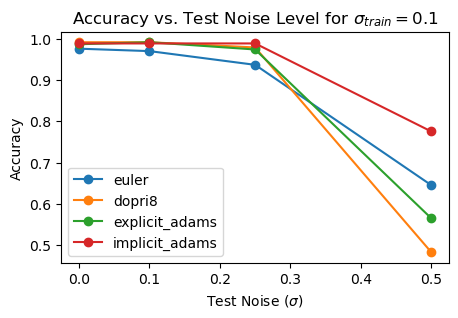

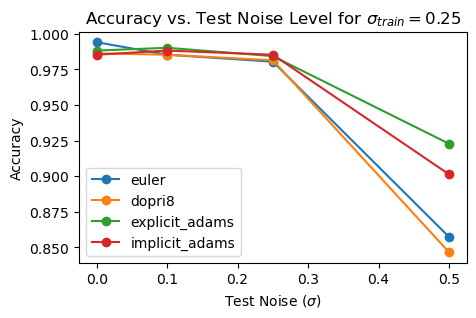

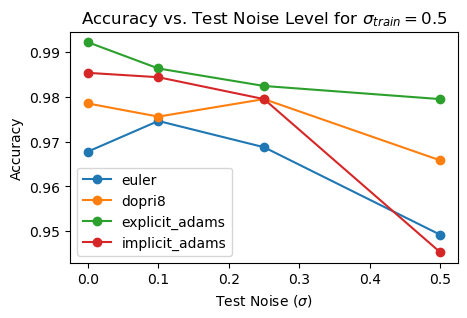

In [51]:
# List all the solvers that will be tested, iterating over each one to load and test the corresponding models.
# solvers = ['dopri5', 'euler', 'rk4', 'explicit_adams','implicit_adams', 'bosh3','fehlberg2', 'euler','midpoint','dopri8','adaptive_heun']
solvers = ['dopri8', 'euler', 'explicit_adams', 'implicit_adams'] # 'midpoint'
noise_levels = [0.0, 0.1, 0.25, 0.5] # Save the noise levels on which to test.

# Iterate over 4 different training noise levels.
for i in range(len(noise_levels)):
    plt.figure(figsize=(5, 3))

    for solver in solvers:
        cur_model_dict = torch.load(f'./AllModels/{solver}/model_{noise_levels[i]}_noise.pth', weights_only=False, map_location='cpu')  # Get the model dictionary from the current model path.
        accuracies = [] # Store the accuracies for each test sigma value (will update each loop).

        # Iterate over 4 different test noise levels.
        for sigma_test in noise_levels:
            # Test on data with maximum noise
            transform = transforms.Compose([
            transforms.RandomCrop(28, padding=4),
            transforms.ToTensor(),
            GaussianNoise(mean=0.0, sigma=sigma_test)
            ])
            mnist = datasets.MNIST(root='./.data/mnist', train=True, transform=transform)
            dataloader = DataLoader(mnist, batch_size=64, shuffle=True)
            def show_images(images, ncols=8):
                nrows = (len(images) + ncols - 1) // ncols
                fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
                for i, ax in enumerate(axes.flat):
                    if i < len(images):
                        ax.imshow(images[i].squeeze(), cmap='gray')
                    ax.axis('off')
                plt.tight_layout()
                plt.show()
            # show_images(next(iter(dataloader))[0])
            
            # Load the state of the current model and set it to evaluation mode in order to pass it test data.
            model.load_state_dict(cur_model_dict['state_dict'])
            model.eval()
            print(f"Testing {solver} solver ")
            
            correct = 0
            total = 0
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                # Iterate over the dataloader to get batches of images and labels, recording the accuracy of the model.
                counter = 0
                for images, labels in dataloader:
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    counter += 1
                    if counter >= 16: # Limit to 8 batches
                        print(f" --- Processed {counter * len(images)} images")
                        break
            
            accuracy = accuracy_score(all_labels, all_preds)
            accuracies.append(accuracy)

            # Test to see if test_model['args'] contains eps variable. Otherwise, set noise to 0 since no noise was added.
            print(f' --- Accuracy of the model with {solver} solver trained at sigma {noise_levels[i]}, testing at sigma {sigma_test}: {accuracy * 100:.2f}% \n')
            
            # cm = confusion_matrix(all_labels, all_preds)
            # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnist.classes)
            # disp.plot(cmap=plt.cm.Blues)
            # plt.title(f'Confusion Matrix for {solver} solver')
            # plt.show()
    
        plt.plot(noise_levels, accuracies, marker='o', label=solver)
        plt.xlabel('Test Noise ($\\sigma$)')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy vs. Test Noise Level for ' + '$\\sigma_{train} = $' + str(noise_levels[i]))
        plt.legend()

    plt.savefig(f'./AllModels/{solver}/accuracy_vs_noise_{noise_levels[i]}_train.png')

In [ ]:
# Identify mismatches in predictions
i_s = range(1000)
for i in i_s:
    with torch.no_grad():
        image = mnist.data[i].unsqueeze(0).unsqueeze(0).float()
        output = model(image)
        output = output.argmax(dim=1).item()
        # print(f"Output for image {i}: {output}")
        # Compare the output with the true label
        true_label = mnist.targets[i].item()
        if output != true_label:
            print(f"Mismatch for image {i}: predicted {output}, true label {true_label}")

            # Show image, and make sure to display all of them
            plt.figure(figsize=(2, 2))
            img_mismatch = mnist.data[i].numpy()
            plt.imshow(img_mismatch)
            plt.show()

In [79]:
img_data = mnist.data[0].unsqueeze(0).unsqueeze(0).float()
print(f"Image pixel range: {img_data.min()} to {img_data.max()}")

Image pixel range: 0.0 to 255.0


In [74]:
cf = confusion_matrix(mnist.targets[:1000].numpy(), [model(mnist.data[i].unsqueeze(0).unsqueeze(0).float()).argmax(dim=1).item() for i in range(1000)])

In [75]:
# Visualize the confusion matrix
def plot_confusion_matrix_basic(cm, class_names=None, title="Confusion Matrix"):
    """Plot confusion matrix using matplotlib"""
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

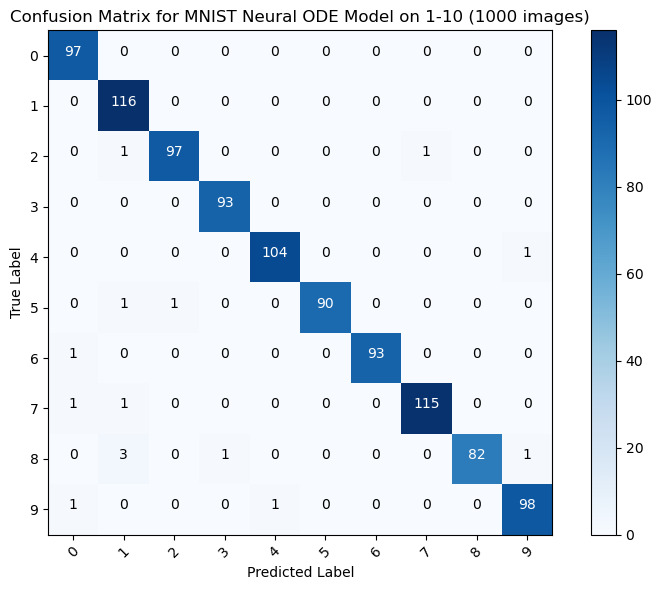

In [76]:
plot_confusion_matrix_basic(cf, class_names=[str(i) for i in range(10)], title="Confusion Matrix for MNIST Neural ODE Model on 1-10 (1000 images)")